<a href="https://colab.research.google.com/github/JCaesarLG/ML-Projects/blob/main/Food_Delivery_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA EXTRACTION

In [ ]:
delivery = pd.read_csv(f"/content/drive/MyDrive/Raw_Data/Food_Delivery_Times.csv")

In [ ]:
delivery.head(10)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
5,679,19.40,Clear,Low,Evening,Scooter,8,9.0,57
6,627,9.52,Clear,Low,NaN,Bike,12,1.0,49
7,514,17.39,Clear,Medium,Evening,Scooter,5,6.0,46
8,860,1.78,Snowy,Low,Evening,Car,20,6.0,35
9,137,10.62,Foggy,Low,Evening,Scooter,29,1.0,73


In [ ]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [ ]:
delivery.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


DATA PREPROCESSING
1. Fill null values in column based on mode & mean from Vehicle Type

In [ ]:
delivery = delivery.drop(columns=['Order_ID'], axis=1)

In [ ]:
modes = {
    'Weather': lambda x: x.mode()[0],
    'Traffic_Level': lambda x: x.mode()[0],
    'Time_of_Day': lambda x: x.mode()[0],
    'Courier_Experience_yrs': lambda x: x.mean().round()
}

for col, func in modes.items():
    mode_map = delivery.groupby('Vehicle_Type')[col].agg(func)
    delivery[col] = delivery[col].fillna(delivery['Vehicle_Type'].map(mode_map))


In [ ]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Weather                 1000 non-null   object 
 2   Traffic_Level           1000 non-null   object 
 3   Time_of_Day             1000 non-null   object 
 4   Vehicle_Type            1000 non-null   object 
 5   Preparation_Time_min    1000 non-null   int64  
 6   Courier_Experience_yrs  1000 non-null   float64
 7   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB


DATA ANALYSIS
1. Graph of categorical and numerical values
2. Checking correlation between columns

In [ ]:
sns.set()

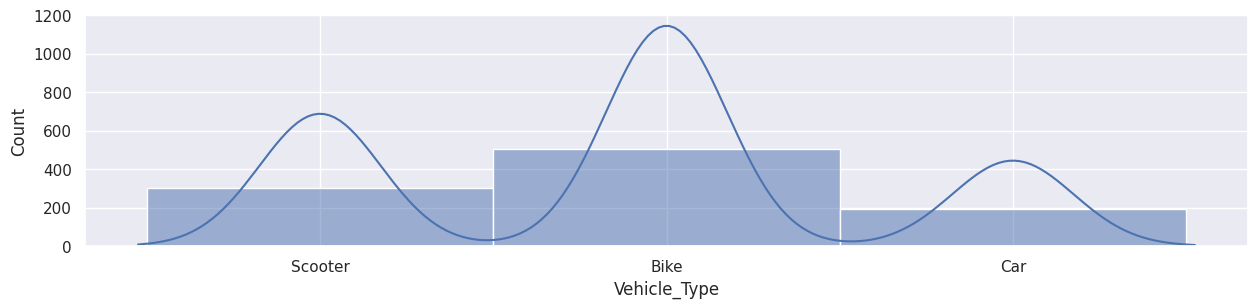

In [ ]:
plt.figure(figsize=(15,3))
sns.histplot(delivery['Vehicle_Type'], kde=True,
             kde_kws=dict(cut=3))
plt.show()

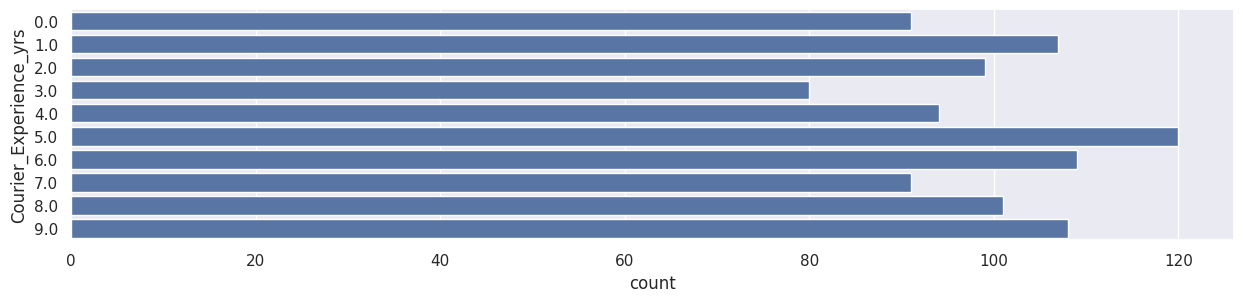

In [ ]:
plt.figure(figsize=(15,3))
sns.countplot(y='Courier_Experience_yrs', data=delivery)
plt.show()

In [ ]:
delivery_cop = delivery.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

columns_encode = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

for col in columns_encode:
  delivery_cop[col] = encoder.fit_transform(delivery_cop[col])

In [ ]:
corr = delivery_cop.corr()

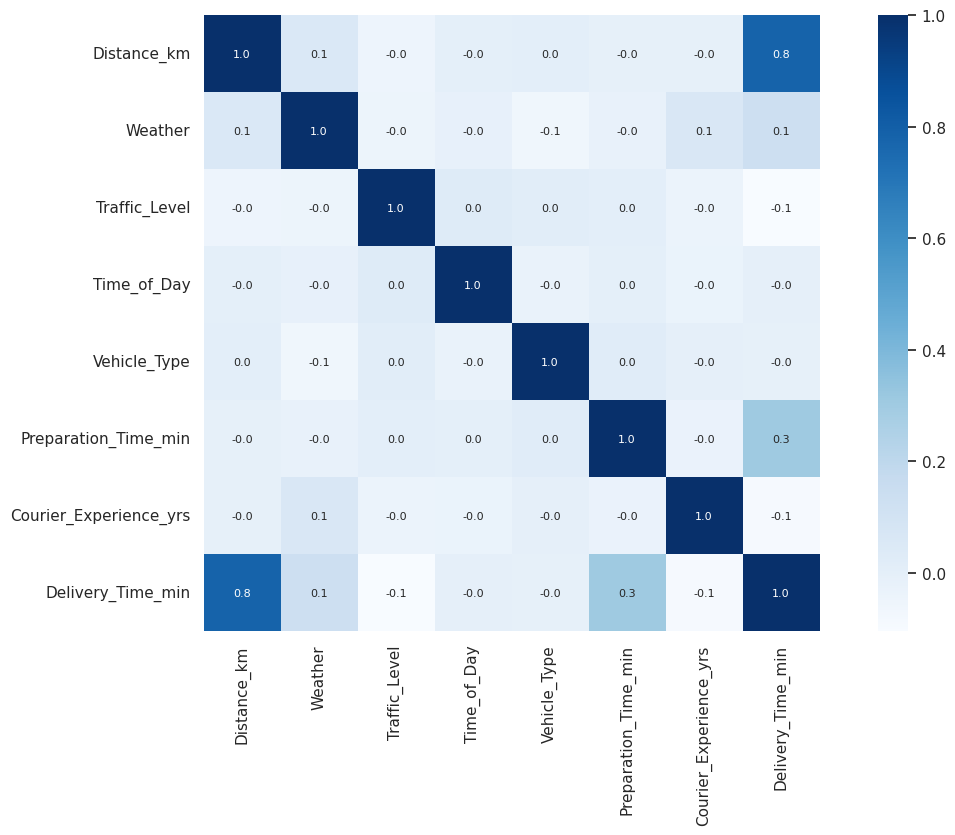

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')
plt.show()

MACHINE LEARNING MODEL BUILDING
1. Import necessary libraries (Random Forest Regressor, LabelEncoder, r2_score, train test split)
2. Encode non numerical value to numerical
3. Fit data to model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = delivery_cop.drop(['Delivery_Time_min'], axis=1)
y = delivery_cop['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regg = RandomForestRegressor(n_estimators=100, random_state=42)
regg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

MODEL EVALUATION
1. r2_score
2. feature importance
3. Predicting

In [ ]:
y_pred_train = regg.predict(X_train)
y_pred_test = regg.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R2 Score for Training Data: {r2_train}")
print(f"R2 Score for Testing Data: {r2_test}")

importance = regg.feature_importances_.round(2)
columns = X.columns
feature_importances = pd.DataFrame({'Feature': columns,
                                    'Importance': importance}).sort_values(by='Importance', ascending=False)

feature_importances

R2 Score for Training Data: 0.9547095907835769
R2 Score for Testing Data: 0.7787037359810841


,Feature,Importance
0,Distance_km,0.70
5,Preparation_Time_min,0.16
6,Courier_Experience_yrs,0.05
1,Weather,0.03
2,Traffic_Level,0.03
3,Time_of_Day,0.02
4,Vehicle_Type,0.02
